# Motion Planning

**Before you start, change to GPU runtime, so rendering cells will run faster.** To do that go to Runtime->Change runtime type->choose T4 GPU and save.
If at some point you get an error that you are out of your GPU quota, you can go back to cpu runtime, some cells will just run slower.

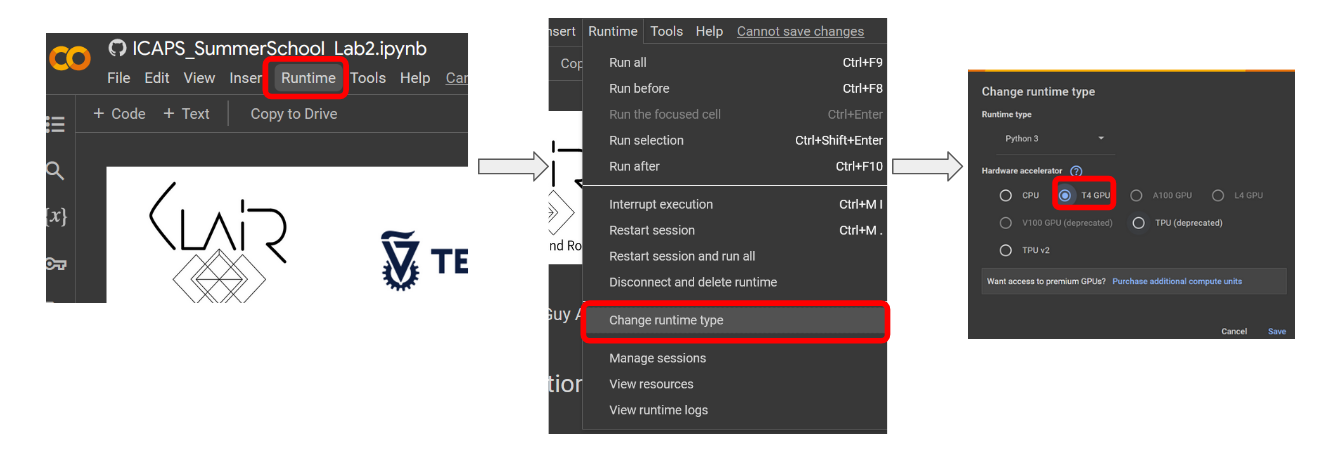

In the previous tutorial, we implemented robot policies based on proportional control. We showed how we could use such controllers to effectively place the end-effector in a desired position in 3D space, and even solved a simple task involving objects. However, such controllers are blind to the environment itself, and only react to the current position of the end-effector. This leaves much to be desired, especially considering the geometry of the robot and the environment.

In this tutorial, we will use motion planning techniques to generate trajectories for the robot to follow, allowing it to navigate around obstacles and reach desired positions safely and efficiently. While the underlying control will still be based on proportional control (specifically, MuJoCo's built-in PD controller), we will generate a sequence of waypoints that the robot can follow to reach its goal.

# Setup

In [1]:
# install required packages
!pip install mujoco
!pip install mediapy
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)

# Enable GPU rendering in Colab
import os
import subprocess
from sys import stderr

try:
  is_gpu = not bool(subprocess.run('nvidia-smi').returncode)
except FileNotFoundError as e:
  is_gpu = False
if is_gpu:
  # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
  # This is usually installed as part of an Nvidia driver package, but the Colab
  # kernel doesn't install its driver via APT, and as a result the ICD is missing.
  # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
  NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
  if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
      f.write("""{
      "file_format_version" : "1.0.0",
      "ICD" : {
          "library_path" : "libEGL_nvidia.so.0"
      }
  }
  """)
else:
  print(
    'Cannot communicate with GPU.\n'
    'Make sure you are using a GPU Colab runtime.\n'
    'Go to the Runtime menu and select Choose runtime type.\n'
    'You can also skip this and use CPU with slower rendering.',
    file=stderr)
  
# Set the EGL backend for MuJoCo
import platform

is_apple_silicon = platform.system() == "Darwin" and platform.processor() == "arm"
if not is_apple_silicon:
  %env MUJOCO_GL=egl

Cannot communicate with GPU.
Make sure you are using a GPU Colab runtime.
Go to the Runtime menu and select Choose runtime type.
You can also skip this and use CPU with slower rendering.


## Obstacles in the Environment

In the last part of the previous tutorial, we added an obstacle to the environment and showed that our simple proportional controller could not handle it.

Let's reload our single-table single-block environment with the obstacle and try to reach the robot's home configuration.

In [2]:
!git clone https://github.com/google-deepmind/mujoco_menagerie
(robot_path,) = !find mujoco_menagerie -name "ur5e.xml"
print(f"UR5e robot MJCF path: {robot_path}\n")

xml = """
<mujoco model="tableworld">
    <statistic center="0.3 0 0.4" extent="0.8"/>

    <visual>
        <headlight diffuse="0.6 0.6 0.6" ambient="0.1 0.1 0.1" specular="0 0 0"/>
        <rgba haze="0.15 0.25 0.35 1"/>
        <global azimuth="45" elevation="-20"/>
    </visual>

    <asset>
        <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512" height="3072"/>
        <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="0.2 0.3 0.4" rgb2="0.1 0.2 0.3"
                 markrgb="0.8 0.8 0.8" width="300" height="300"/>
        <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5" reflectance="0.2"/>
    </asset>

    <worldbody>
        <light pos="0 0 1.5" dir="0 0 -1" directional="true"/>
        <geom name="floor" pos="0.0 0.0 0.0" size="0 0 0.05" type="plane" material="groundplane"/>

        <body name="table" pos="0.3 0.0 0">
            <geom name="table_top" type="box" size=".37 .37 .01" pos="0 0 .7"/>
            <geom name="table_leg_1" type="cylinder" size=".01 .7" pos=".24 -.24 -.0" euler="0 0 0"/>
            <geom name="table_leg_2" type="cylinder" size=".01 .7" pos=".24 .24 -.0" euler="0 0 0"/>
            <geom name="table_leg_3" type="cylinder" size=".01 .7" pos="-.24 -.24 -.0" euler="0 0 0"/>
            <geom name="table_leg_4" type="cylinder" size=".01 .7" pos="-.24 .24 -.0" euler="0 0 0"/>
        </body>

        <body name="red_box" pos="0.3 0 0.76" quat="0. 0. 1. 0.">
            <freejoint/>
            <geom name="red_box_geom" type="box" size=".05 .05 .05" rgba="1 0 0 1"/>
        </body>

        <geom name="obstacle" type="box" size=".05 .3 .05" pos="0.3 0 1.1" rgba="0 0 1 1"/>

        <!--angle view-->
        <camera name="rightangleview" pos="2.182 1.724 2.590" xyaxes="-0.685 0.729 0.000 -0.456 -0.429 0.780"/>
        <camera name="leftangleview" pos="2.182 -1.724 2.590" xyaxes="0.685 0.729 0.000 -0.456 0.429 0.780"/>
        <!-- front view -->
        <camera mode="fixed" name="frontview" pos="2.5 0 1.45" quat="0.56 0.43 0.43 0.56"/>
        <!-- bird view -->
        <camera mode="fixed" name="birdview" pos="0.3 0 3.0" quat="0.7071 0 0 0.7071"/>
        <!-- side view -->
        <camera mode="fixed" name="leftsideview" pos="0.151 -2.941 0.9" xyaxes="1.000 0.000 0.000 0.000 0.000 1.000"/>
        <camera mode="fixed" name="rightsideview" pos="0.151 2.941 0.9" xyaxes="-1.000 0.000 0.000 0.000 0.000 1.000"/>

    </worldbody>

</mujoco>
"""

import mujoco
import mediapy as media

scene_spec = mujoco.MjSpec.from_string(xml)
robot_spec = mujoco.MjSpec.from_file(robot_path)

# create a mount (body + site) in the parent where the robot should attach
mount = scene_spec.worldbody.add_body(name="mount", pos=[0.0, 0.0, 0.72], xyaxes=[-1, 0, 0, 0, -1, 0])
mount_site = mount.add_site(name="mount_site", pos=[0, 0, 0])

# attach the entire robot spec to the parent's mount site (prefix renames attached elements)
scene_spec.attach(robot_spec, site=mount_site, prefix="robot_")

# compile into a model and data
model = scene_spec.compile()
data = mujoco.MjData(model)

mujoco.mj_resetData(model, data)  # Reset state and time.

data.ctrl = [0, -1.57, 1.57, -1.57, -1.57, 0]  # initial joint positions


duration= 1.0 # seconds
framerate = 60  # frames per second

frames = []
with mujoco.Renderer(model) as renderer:
    while data.time < duration:
        mujoco.mj_step(model, data)

        if len(frames) < data.time * framerate:
            renderer.update_scene(data, camera="leftsideview")
            pixels = renderer.render()
            frames.append(pixels)

media.show_video(frames, fps=framerate)

fatal: destination path 'mujoco_menagerie' already exists and is not an empty directory.
UR5e robot MJCF path: mujoco_menagerie/universal_robots_ur5e/ur5e.xml



Before we introduced this obstacle, we looked at the world as a clear space, where the robot's end-effector could move freely, and the robot could reach any configuration. We will now see how obstacles affect the robot's configuration space.

## Workspace and Configuration Space

Two important concepts we need to know to better understand the state representation are the **workspace** and **configuration space**.


In the context of robotics, the workspace refers to the physical space in which a robot operates. This includes all the points in the robot's reach or the volume within which the end-effector or any part of the robot can move. It is often more intuitive to define our tasks and goals in the workspace, as it directly relates to the robot's interaction with its environment.


Configuration space, often abbreviated as C-space, represents all possible states or configurations of a robot, where each point in this space corresponds to a unique position and orientation of the robot. In C-space, obstacles are represented as regions that the robot's configuration cannot occupy.

The configuration space is likely multi-dimensional, depending on the number of degrees of freedom (DOF) of the robot, typically representing its controllable joints. Thus, a **configuration** corresponds to a unique position and orientation of the robot in its workspace.

Let's explore the relationship between the workspace and the configuration space. [Click here](https://robotics.cs.unc.edu/C-space/index.html) to open an online demo app created by Prof. Ron Alterovitz's from UNC where we can play around with a 2-DOF robotic arm and see the mapping between the spaces.  

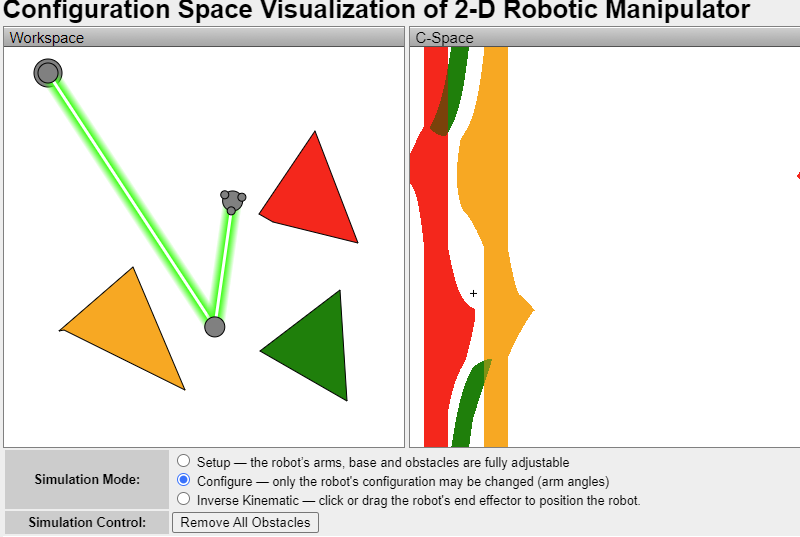

**NOTE:** In the demo, the robot cannot collide with itself. However, in real-world applications, self-collisions are a critical consideration in motion planning and must be accounted for to ensure safe and effective robot operation.

For our robotic arm, the workspace would be the volume of space around the base within which the arm can position its end-effector.

It's configuration space space has $6$ DOFs for each of its joints.


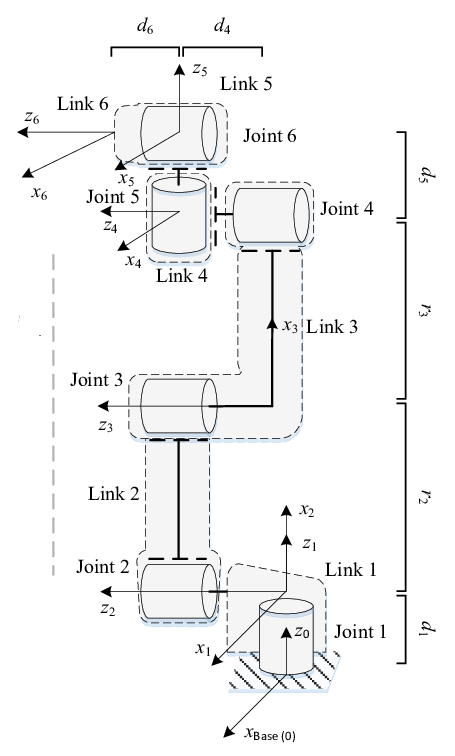

## Mapping Between Spaces

We would like to use the UR5e robot to manipulate objects in its workspace. For this, we need to place the end effector at specific coordinates and orientation within the workspace, i.e., the physical space where the robot interacts with objects. This task requires converting between the workspace and the C-space.

![forward and inverse kinematic](https://github.com/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/assets/figures/f_inv_kinematics.png?raw=true)

The process of mapping from a robot's configuration—specifically its joint angles—to the workspace—where the end effector's position and orientation are defined—is known as **forward kinematics**. This mapping is indeed feasible and relatively intuitive if we know the robot's geometric parameters, such as the lengths and relative positions of its links. The computation of the end effector's pose from the joint configurations is typically represented using matrix multiplications. These matrices, often referred to as transformation matrices, sequentially transform the pose from one joint to the next along the robot's arm, ultimately resulting in the pose of the end effector in the workspace.

As in the previous tutorial, we will bypass implementing forward kinematics for the UR5e robot using by getting the end effector's pose directly from the simulation environment:

In [3]:
def get_ee_pose(data: mujoco.MjData):
    attachment_site = data.site('robot_attachment_site')
    
    return attachment_site.xpos, attachment_site.xmat.reshape(3, 3)

**Inverse kinematics (IK)** involves determining the joint configurations that will achieve a specified position and orientation of the end effector in the workspace. This process is the reverse of forward kinematics and can be more complex because there may be multiple, or even an infinite number of, joint configurations that can result in the same end effector pose. IK essentially frames this challenge as an optimization problem, where the goal is to find the best set of joint angles that satisfy the end effector's target position and orientation. Unlike the direct calculations used in forward kinematics, solving inverse kinematics often requires the use of numerical methods and optimization techniques to find feasible solutions. However, there are analytical solutions for specific robot configurations, including the UR5e, which can provide exact joint angles for given end effector poses.

The `ur-analytic-ik` library provides an analytical solution for the inverse kinematics of the UR5e robot natively in python. Let's install it:

In [4]:
!pip install ur-analytic-ik

We will now implement a function to compute the inverse kinematics using this library:

In [5]:
from ur_analytic_ik import ur5e
import numpy as np

def compute_ik(target_pos, target_rot_mat):
    # ur-analytic-ik expects the end-effector pose in the robot's base frame.
    # The target_pos and target_quat are given in the world frame.
    # We need to account for the mount's translation and orientation if necessary.
    mount_body = model.body('mount')
    mount_pos, mount_quat = mount_body.pos, mount_body.quat
    
    # First, get the relative position
    rel_pos = target_pos - mount_pos

    # Convert mount quaternion to rotation matrix for inverse transform
    mount_rot_mat = np.empty(9)
    mujoco.mju_quat2Mat(mount_rot_mat, mount_quat)
    mount_rot_mat = mount_rot_mat.reshape(3, 3)

    # Apply inverse rotation to get position in mount frame
    target_pos = mount_rot_mat.T @ rel_pos

    # Compute relative rotation: R_relative = R_mount^T * R_target
    target_rot_mat = mount_rot_mat.T @ target_rot_mat

    # Compute IK solutions
    pose = np.identity(4)
    pose[:3, 3] = target_pos
    pose[:3, :3] = target_rot_mat
    ik_solutions = ur5e.inverse_kinematics(pose)

    return ik_solutions


Let's test it out. We will bring the robot to it's home configuration and get the end effector's pose. Then, we will use our `compute_ik` function to compute the joint angles that would bring the end effector to this pose and compare the results.

In [6]:
mujoco.mj_resetData(model, data)
data.qpos[7:] = [0, -1.57, 1.57, -1.57, -1.57, 0]  # home configuration
mujoco.mj_forward(model, data)  # Update the simulation state
home_config_ee_pos, home_config_ee_rot = get_ee_pose(data)

sols = compute_ik(home_config_ee_pos, home_config_ee_rot)
sols

[array([ 1.42215943e-03, -1.07157537e+00,  9.39087804e-01,  1.70407908e+00,
         1.56999887e+00, -3.14017049e+00]),
 array([ 1.42215943e-03, -1.73212393e-01, -9.39087804e-01,  2.68389172e+00,
         1.56999887e+00, -3.14017049e+00]),
 array([ 1.42215943e-03, -1.56931820e+00,  1.56906328e+00, -1.56974622e+00,
        -1.56999887e+00,  1.42215943e-03]),
 array([ 1.42215943e-03, -8.03471821e-02, -1.56906328e+00,  7.94093307e-02,
        -1.56999887e+00,  1.42215943e-03]),
 array([-2.61154575, -3.06136491,  1.5691932 ,  3.06268358,  1.57188599,
         0.53004707]),
 array([-2.61154575, -1.57227437, -1.5691932 , -1.57120586,  1.57188599,
         0.53004707]),
 array([-2.61154575, -2.96824709,  0.93892681,  0.4582395 , -1.57188599,
        -2.61154558]),
 array([-2.61154575, -2.07003699, -0.93892681,  1.43788301, -1.57188599,
        -2.61154558])]

There are many possible solutions. Are all of them valid? Does any of them match the home configuration?

In [7]:
from ipywidgets import interact

@interact(ik_solution_number=(0, len(sols)-1), camera=["leftsideview", "rightsideview", "frontview", "birdview", "leftangleview", "rightangleview"])
def render_ik_solution(ik_solution_number, camera="leftsideview"):
    data.qpos[7:] = sols[ik_solution_number]  # apply one of the IK solutions
    mujoco.mj_forward(model, data)  # Update the simulation state
    with mujoco.Renderer(model) as renderer:
        renderer.update_scene(data, camera=camera)
        media.show_image(renderer.render())

interactive(children=(IntSlider(value=3, description='ik_solution_number', max=7), Dropdown(description='camer…

""

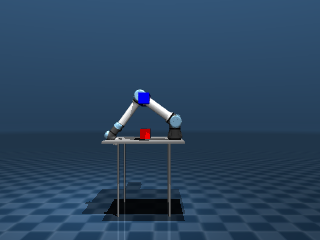

In [8]:
from math import pi

data.qpos[7:] = [0, -pi/5, 1.57, -1.57, -1.57, 0]  # home configuration
mujoco.mj_forward(model, data)  # Update the simulation state
with mujoco.Renderer(model) as renderer:
    renderer.update_scene(data, camera='rightsideview')
    media.show_image(renderer.render())

## Sampling-Based Motion Planning Algorithms

The configuration space, or C-space, represents all possible orientations and positions of a robot's joints. A crucial part of this space is the 'free space,' which consists of configurations that avoid any collisions with obstacles or the robot itself. Successfully identifying and navigating within this free space is essential for effective motion planning.


Representing the free space within the configuration space is a complex challenge due to the intricate geometry translated from the workspace into a high-dimensional space. Specifically, the configuration space is six-dimensional, corresponding to the robot's six joints. This complexity makes accurately modeling the exact geometry both difficult and computationally intensive. One way to deal with this is to employ sampling methods that allow us to approximate which areas of the configuration space are free from collisions. By randomly sampling points across this six-dimensional space, we can efficiently identify (probably) feasible paths for the robot, bypassing the need for a complete and detailed representation of all possible configurations.


After determining which samples fall within the free space, the next step is to connect these points. We attempt to draw straight paths between neighboring points in the configuration space, consistently checking, via forward kinematics, that these paths do not intersect any obstacles in the workspace. This iterative process of checking and connecting points forms the backbone of constructing a viable path for the robot.

Collision detection is a major bottleneck in this process due to its computational demands. To enhance efficiency, we often use simplified geometric models of the robot and its environment. This reduction in complexity speeds up the collision checks without significantly compromising the accuracy of the path planning.

The figure below (taken from http://motion.cs.illinois.edu/RoboticSystems/figures/planning/prm.svg) illustrates a sampling-based motion planning algorithm applied within a 2D configuration space. This simplification helps visualize the concept more easily. However, it is crucial to remember that our robot operates within a 6D domain, making the actual problem significantly more complex.
![motion planning](http://motion.cs.illinois.edu/RoboticSystems/figures/planning/prm.svg)
Here's how the process unfolds in the figure:

* a. demonstrates how a single point is sampled. The motion planner must have the ability to check whether a point in configuration space is within collision or not. The point sampled in this example is within a collision, thus it can't be part of a path
* b. we sample many points, and drop those that are not in the free space
* c. we add the start and goal points
* d. we try to connect each point to its neighbors and check if the line that connects them doesn't hit an obstacle (note that this is typically a costly operation)
* e. a roadmap is built,
* f. we search for a path from start to goal along this roadmap.


The algorithm described is known as **Probabilistic Road Map (PRM)** (Kavraki et al. 1996), which is effective for planning paths in a variety of environments by randomly sampling points and connecting them in a network. Another popular type of sampling-based motion planning algorithm is the **Rapidly-exploring Random Tree (RRT)** (LaValle 1998). RRT works by incrementally building a tree that branches out from the starting point into the configuration space. It begins by randomly sampling a point and connecting it to the nearest existing node in the tree, provided the path between these points is free of obstacles. This process continues, rapidly expanding the tree until it reaches the vicinity of the goal state or covers a significant portion of the space. RRT is particularly favored for its ability to quickly find a feasible path, even in high-dimensional spaces, making it suitable for environments where obstacles are dense and planning must be done quickly.



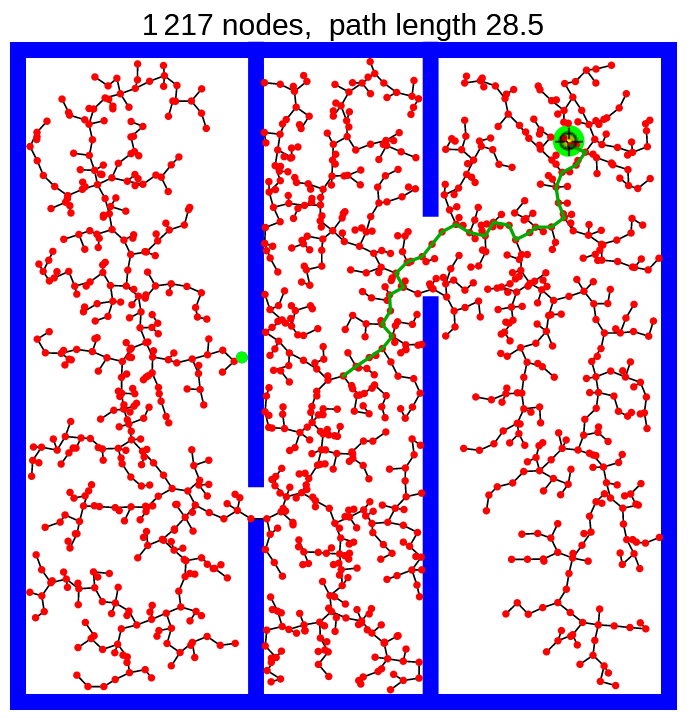

A search tree built by the RRT algorithm in a 2D configuration space.

Follow [this link](https://demonstrations.wolfram.com/RapidlyExploringRandomTreeRRTAndRRT/) to see RRTs in action. This demo was created by Aaron T. Becker and Li Huang.

## The Open Motion Planning Library (OMPL)

Both PRM and RRT are foundational techniques in robotic motion planning, each with unique strengths making them suitable for different scenarios in robotics and automated systems. Therefore, there are many available implementations of these algorithms. We will be using the [Open Motion Planning Library](https://ompl.kavrakilab.org) (OMPL) which provides a robust, efficient, and minimal implementation of RRT*.

In [9]:
!pip install ompl

OMPL is a powerful open-source library, offering a wide range of sampling-based motion planning algorithms and tools to facilitate the development of robotic applications. It is widely used in both academic research and industry for its efficiency and versatility in solving complex problems. It is even the backbone of the the popular [MoveIt framework for ROS](https://moveit.picknik.ai/humble/doc/examples/ompl_interface/ompl_interface_tutorial.html).

### Defining the configuration space

Sampling-based planners like RRT and PRM operate in C-space. We must first inform OMPL of the limits of our robot's C-space. Let's start by defining a real-valued state space with six degrees of freedom using the `RealVectorStateSpace` class:

In [10]:
from ompl import base as ob

state_space = ob.RealVectorStateSpace(6)  # 6 DOFs for UR5e

The state space we have created is infinite in all directions. We can set bounds on each dimension to create a finite C-space. Robots typically define joint limits in their description files. MuJoCo enables us to access these limits directly from the model. Let's set the bounds of our state space to match the joint limits of our robot:

In [11]:
def get_joint_bounds(model: mujoco.MjModel) -> list[tuple[float, float]]:
    bounds = []
    for i in range(model.njnt):
        joint = model.joint(i)
        if not joint.name.startswith("robot"):
            continue
        bounds.append((joint.range[0], joint.range[1]))
    return bounds

joint_bounds = get_joint_bounds(model)

We can add those bounds into our state space using the `RealVectorBounds` class:

In [12]:
# initialize a bounds object
bounds = ob.RealVectorBounds(6)

# iterate discovered joint bounds and set them in the bounds object
for i in range(6):
    low, high = joint_bounds[i]
    bounds.setLow(i, low)
    bounds.setHigh(i, high)

# add the bounds to the state space
state_space.setBounds(bounds)

### Free Space and Collision Space

Our C-space now matches the joint limits of our robot. However, the entire C-space is currently considered as free space. Our state space object does not include obstacles directly. However, since we are using sampling-based planners, all we care about is whether a given state is valid (i.e., collision-free) or not. Therefore, all we need to do is define a state validity checker that can determine if a given state is in collision with any obstacles in the environment.

Instead of just providing collision data, the MuJoCo `data` object provides detailed contact information between `geom` elements. Let's run the simulation for a few steps to ensure that the contact simulation is in a stable state and then check the collision data:

In [13]:
# reset mujoco simulation data
mujoco.mj_resetData(model, data)

data.ctrl[:] = 0

for i in range(10):
    mujoco.mj_step(model, data)

print('number of contact points:', data.ncon)

for i in range(data.ncon):
    contact = data.contact[i]
    geom1_name = model.geom(contact.geom1).name
    geom2_name = model.geom(contact.geom2).name
    print(f'Contact {i}: between "{geom1_name}" and "{geom2_name}"')

number of contact points: 4
Contact 0: between "table_top" and "red_box_geom"
Contact 1: between "table_top" and "red_box_geom"
Contact 2: between "table_top" and "red_box_geom"
Contact 3: between "table_top" and "red_box_geom"


As expected, the table-top and the red box are in contact. There is more information available in the contact data, such as contact points and forces. We can visualize this in MuJoCo:

""

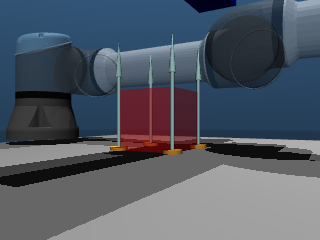

In [14]:
# visualize contact frames and forces, make body transparent
options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True  # show contact points
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True  # show contact forces
options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True   # make bodies transparent for better visibility

# tweak scales of contact visualization elements
model.vis.scale.contactwidth = 0.05   # radius of contact point circles
model.vis.scale.contactheight = 0.02  # width of contact point circles
model.vis.scale.forcewidth = 0.01     # width of contact force arrows
model.vis.map.force = 0.5             # scale for force magnitude (arrow length per Newton)

# add a new camera adjacent to the box
box_cam = mujoco.MjvCamera()
box_cam.lookat = [0.3, 0, 0.76]  # look at the box
box_cam.distance = 0.5           # half a meter from the box
box_cam.elevation = 0            # level with the box
box_cam.azimuth = 120            # 120 degrees around the box (see all forces)

with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data, camera=box_cam, scene_option=options)
    media.show_image(renderer.render())

Let's use this contact information to define a collision-checking function. Note that we only need to care about collisions with the robot since this is the body we are planning for. For example, it is ok for the red box to be in contact with the table-top.

In [15]:
def robot_collision(model: mujoco.MjModel, data: mujoco.MjData) -> bool:
    # Check for collision between robot and environment
    # do not count collision between objects and themselves
    for i in range(data.ncon):
        # get contact info
        contact = data.contact[i]

        # get the names of the bodies involved in the contact
        geom1_body_id = model.geom(contact.geom1).bodyid[0]
        geom1_body_name = model.body(geom1_body_id).name
        geom2_body_id = model.geom(contact.geom2).bodyid[0]
        geom2_body_name = model.body(geom2_body_id).name

        if geom1_body_name.startswith("robot") or geom2_body_name.startswith("robot"):
            return True  # Collision detected

    return False  # No collision detected

We are now ready to define the state validity checker for our planning problem. OMPL allows us to define a custom state validity checker by inheriting from the `StateValidityChecker` class. This class implements a method called `isValid` which receives a `State` object (an array of joint values in our case) and returns a boolean indicating whether the state is valid (collision-free) or not.

To implement this function, we will update the simulation data with the provided joint values and check for collisions using the contact information from MuJoCo. **NOTE**: simply setting the `qpos` values changes the robot position but does not update the rest of the simulation data. To update the simulation, we need to call `mj_forward` which syncs the rest of the simulation data with the new joint positions.

In [16]:
from ompl import base as ob


class UR5eValidityChecker(ob.StateValidityChecker):
    def __init__(
        self,
        state_info: ob.SpaceInformation,
        model: mujoco.MjModel,
        data: mujoco.MjData,
    ):
        super().__init__(state_info)
        self.model = model
        self.data = data

    def isValid(self, state: ob.State) -> bool:
        # Set the robot's joint positions to the given state
        for i in range(6):
            self.data.qpos[7 + i] = state[i]
        mujoco.mj_forward(self.model, self.data)  # Update the simulation state

        # Check for collision between robot and environment
        return not robot_collision(self.model, self.data)

Notice that the validity checker is constructed using a `SpaceInformation` object. This object wraps the state space together with the validity checker, defining the full C-space with obstacle information. Let's create this object now:

In [17]:
# instantiate on our C-space
state_info = ob.SpaceInformation(state_space)

# set the validity checker
state_info.setStateValidityChecker(UR5eValidityChecker(state_info, model, data))

# sets how the segment between two states is divided for collision checking
# lower values lead to more fine-grained checking but slower performance
state_info.setStateValidityCheckingResolution(0.1)

# finalize the setup of the space information object
state_info.setup()

### Defining the Planning Problem

We now have a fully representative C-space in the form of a `SpaceInformation` object. The next step is to define the planning problem itself. This involves specifying the start and goal states for the robot and initializing a `ProblemDefinition` object:

In [18]:
# define start and goal configurations
start_q = [0, 0, 0, 0, 0, 0]  # initial configuration
goal_q = [0, -1.57, 1.57, -1.57, -1.57, 0]  # home configuration

# create start and goal states in the state space
start_state = ob.State(state_space)
goal_state = ob.State(state_space)

# set the values of the start and goal states to the desired configurations
for i in range(6):
    start_state[i] = start_q[i]
    goal_state[i] = goal_q[i]

# initialize the problem definition
pdef = ob.ProblemDefinition(state_info)

# set start and goal states, as well as the error tolerance for reaching the goal
pdef.setStartAndGoalStates(start_state, goal_state, threshold=0.01)

### Configuring the Planner

OMPL provides a straightforward interface to configure and use planners. Let's create an instance of the RRT* planner and set it up with our `SpaceInformation` and `ProblemDefinition` objects:

In [26]:
import ompl.geometric as og

# initialize the planner
planner = og.RRTstar(state_info)

# set the maximum step size between two states
# smaller values lead to a denser tree but slower performance
planner.setRange(0.5)

# configure the planner with the problem definition
planner.setProblemDefinition(pdef)

# finalize the planner setup
planner.setup()

There are many more configurations available for the RRT* planner. For example, you can set pruning branch rules or choose the data structure used to store the tree for more efficient nearest-neighbor searches. For our purposes, we will stick with mostly default settings.

### Planning the Path

OMPL planners implement the `solve` method to perform the planning. This method takes a time limit (in seconds) as an argument and returns a status indicating whether a solution was found within the time limit. Throughout execution, the planner will output logs to the console, providing insights into its progress. Let's invoke the planner now:

In [ ]:
import sys

solved = planner.solve(10.0)  # 10 seconds time limit
sys.stdout.flush()  # flush output to ensure logs are printed before proceeding

if solved.getStatus() == ob.PlannerStatus.EXACT_SOLUTION:
    print("Found solution.")
else:
    print("No solution found.")

Error:   Random number generation already started. Changing seed now will not lead to deterministic sampling.
         at line 80 in /Users/runner/work/ompl/ompl/src/ompl/util/src/RandomNumbers.cpp


Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 6.39 in 191 iterations (89 vertices in the graph)
Info:    RRTstar: Created 7534 new states. Checked 21594609 rewire options. 1 goal states in tree. Final solution cost 6.387
Found solution.


Did your planner find a solution? Remember that RRT* is a randomized algorithm, so it may not always find a solution within the given time limit, especially in complex environments. Try rerunning the previous cell. The planner will continue from where it left off, so it may find a solution on subsequent attempts. You can also reinitialize the planner to start fresh.

Now that we have a solution, we can extract the planned path from the `ProblemDefinition` object. The path is represented as a sequence of states (joint configurations) that the robot should follow to reach the goal:

In [35]:
# a container for the plan waypoint states
waypoints = []

path = pdef.getSolutionPath()
print("number of waypoints in solution:", path.getStateCount())

# optional: interpolate the waypoints for smoother path
path.interpolate(100)

# extract the waypoints from the path
for i in range(path.getStateCount()):
    state = path.getState(i)
    waypoint = [state[j] for j in range(6)]
    waypoints.append(waypoint)

for waypoint in waypoints:
    print(waypoint)

number of waypoints in solution: 100
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.0035949767650283334, -0.012055958243671104, -0.017248873257792802, -0.038955302089430766, -0.038470767638864325, 0.021282407303218003]
[-0.007189953530056667, -0.02411191648734221, -0.034497746515585605, -0.07791060417886153, -0.07694153527772865, 0.042564814606436005]
[-0.010784930295085, -0.036167874731013315, -0.05174661977337841, -0.1168659062682923, -0.11541230291659298, 0.063847221909654]
[-0.014379907060113334, -0.04822383297468442, -0.06899549303117121, -0.15582120835772306, -0.1538830705554573, 0.08512962921287201]
[-0.017974883825141667, -0.06027979121835552, -0.08624436628896401, -0.19477651044715383, -0.1923538381943216, 0.10641203651609002]
[-0.02156986059017, -0.07233574946202663, -0.10349323954675682, -0.2337318125365846, -0.23082460583318595, 0.127694443819308]
[-0.025164837355198335, -0.08439170770569773, -0.12074211280454962, -0.27268711462601536, -0.2692953734720503, 0.148976851122526]
[-0.028759

Let's run the plan and see our solution in action:

In [40]:
from copy import copy


def render_plan(
    waypoints,
    arrived_at_waypoint_tolerance=0.2,
    duration=5.0,
    framerate=60,
    camera="leftsideview",
):
    waypoints = copy(waypoints)

    # reset simulation
    mujoco.mj_resetData(model, data)

    # set to start configuration
    cur_waypoint = waypoints.pop(0)
    data.qpos[7:] = cur_waypoint
    mujoco.mj_forward(model, data)

    frames = []
    with mujoco.Renderer(model) as renderer:
        while data.time < duration:
            data.ctrl[:] = cur_waypoint  # set control to next waypoint

            mujoco.mj_step(model, data)

            if len(frames) < data.time * framerate:
                renderer.update_scene(data, camera=camera)
                pixels = renderer.render()
                frames.append(pixels)

            # if close enough to next waypoint, pop it
            is_close = np.allclose(
                data.qpos[7:], cur_waypoint, atol=arrived_at_waypoint_tolerance
            )
            if is_close and len(waypoints) > 0:
                cur_waypoint = waypoints.pop(0)

    media.show_video(frames, fps=framerate)
    return frames


fms = render_plan(waypoints, duration=5.0, framerate=60, camera="frontview")

## Conclusion

In this tutorial, we explored the fundamentals of motion planning with an emphasis on sampling-based motion planners. We discussed the concepts of configuration space, free space, and collision space, and how they relate to robotic motion planning. We then implemented our own motion planning problem using OMPL for our MuJoCo robot model and solved it using RRT*.

Notice a hidden feature of our state space implementation: it is not static! Since the robot can collide with itself, the free space and collision space can change based on the robot's configuration. We get this feature for free when we define the free space using a validity checker for sampling-based approaches. However, there are other challenges that arise when planning for robots that manipulate objects. You will explore these challenges in more detail in the homework assignment.

So far, we have been making assumptions about our knowledge about the environment. Our controller knew exactly where it needed to go in 3D space, and our motion-planner gets a precise desired configuration. In the next tutorial, we will explore how robots can perceive their environment based on sensor data.